In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data.csv', index_col=False)
df = df[df['deviceuuid'] == 'aNyZC8jwH3']
df = df[['create_time','weight', 'skeletal_muscle_mass', 'body_fat_mass', 'body_fat']]
df['create_time'] = pd.to_datetime(df['create_time'])
df = df.sort_values(by='create_time')
# group by day
df['day'] = df['create_time'].dt.date
df = df.groupby('day').mean()
df = df.reset_index()
df = df.drop(columns=['create_time'])
df = df.round(2)
df.to_csv('proc_data.csv', index=False)
df['day'] = pd.to_datetime(df['day'])
df = df[df['day'] >= datetime(2024, 3, 1)]
# df = df[df['day'] <= datetime(2024, 12, 1)]
print('last date', df['day'].max())
df = df.rename(columns={'body_fat': 'body_fat_percentage', 'skeletal_muscle_mass': 'muscle_mass'})
# Calculate monthly means and standard deviations
df_monthly = df.groupby(pd.Grouper(key='day', freq='ME')).agg({
    'weight': ['mean', 'std'],
    'muscle_mass': ['mean', 'std'],
    'body_fat_mass': ['mean', 'std'],
    'body_fat_percentage': ['mean', 'std']
})

# Flatten column names and reset index
df_monthly.columns = ['_'.join(col).strip() for col in df_monthly.columns]
df_monthly = df_monthly.reset_index()
df_monthly = df_monthly.round(2)
df_monthly['label'] = df_monthly['day'].dt.strftime('%Y-%m')

# Calculate month-to-month variations
for metric in ['weight', 'muscle_mass', 'body_fat_mass', 'body_fat_percentage']:
    mean_col = f'{metric}_mean'
    df_monthly[f'{metric}_variation'] = df_monthly[mean_col].diff()
# replace nan with 0
df_monthly = df_monthly.fillna(0)
df_monthly['muscle_mass_percentage_mean'] = df_monthly['muscle_mass_mean'] / df_monthly['weight_mean'] * 100
df_monthly['body_fat_mass_percentage_mean'] = df_monthly['body_fat_mass_mean'] / df_monthly['weight_mean'] * 100
df_monthly = df_monthly.round(2)
df_monthly.tail()

last date 2025-03-30 00:00:00


,day,weight_mean,weight_std,muscle_mass_mean,muscle_mass_std,body_fat_mass_mean,body_fat_mass_std,body_fat_percentage_mean,body_fat_percentage_std,label,weight_variation,muscle_mass_variation,body_fat_mass_variation,body_fat_percentage_variation,muscle_mass_percentage_mean,body_fat_mass_percentage_mean
10,2024-11-30,65.14,0.40,29.90,0.30,10.12,0.26,15.53,0.41,2024-11,0.89,0.37,0.26,0.19,45.90,15.54
11,2024-12-31,65.49,0.26,30.25,0.23,9.92,0.35,15.15,0.52,2024-12,0.35,0.35,-0.20,-0.38,46.19,15.15
12,2025-01-31,66.00,0.33,30.23,0.28,10.42,0.28,15.79,0.43,2025-01,0.51,-0.02,0.50,0.64,45.80,15.79
13,2025-02-28,66.07,0.35,30.30,0.24,10.38,0.34,15.72,0.48,2025-02,0.07,0.07,-0.04,-0.07,45.86,15.71
14,2025-03-31,66.51,0.31,30.62,0.27,10.31,0.30,15.50,0.45,2025-03,0.44,0.32,-0.07,-0.22,46.04,15.50


In [5]:
def plot_monthly_variation(df_monthly:pd.DataFrame, metric:str, metric_label:str, positive: bool = True):
	# Create figure and set background color
	fig, ax = plt.subplots(figsize=(12, 12))
	fig.patch.set_facecolor('#1a2024')
	ax.set_facecolor('#1a2024')

	# Remove top and right spines
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)

	# Style the remaining spines
	ax.spines['bottom'].set_color('gray')
	ax.spines['left'].set_color('gray')

	# Plot the main line
	ax.plot(df_monthly['label'], df_monthly[f'{metric}_mean'],
			label=f'{metric_label}', marker='o',
			markerfacecolor='#1a2024', markeredgecolor='#0767e6',
			color='#0767e6')

	# Add variation labels with colored backgrounds
	for i, (date, value, variation) in enumerate(zip(df_monthly['label'],
											df_monthly[f'{metric}_mean'],
											df_monthly[f'{metric}_variation'])):
			if pd.notna(variation) and i > 0:
					if positive:
						bg_color = '#2d614d' if variation > 0 else '#614d4d'
						xy=(date, value+0.01) if variation > 0 else (date, value-0.1)
					else:
						bg_color = '#614d4d' if variation > 0 else '#2d614d'
						xy=(date, value+0.01) if variation > 0 else (date, value-0.05)
					text_color = 'white'


					ax.annotate(f'{variation:+.2f}',
									xy=xy,
									xytext=(0, 10),
									textcoords='offset points',
									ha='center',
									color=text_color,
									bbox=dict(boxstyle='round,pad=0.5',
											fc=bg_color,
											ec=None,
											alpha=0.9))


	# Style the grid and labels
	ax.grid(True, linestyle='--', alpha=0.2, color='gray')
	ax.set_title(f'Average {metric_label} per month', pad=20, color='white')
	ax.set_xlabel('Date', color='white')
	ax.set_ylabel(f'{metric_label} (kg)', color='white')
	ax.tick_params(colors='white')
	ax.legend(facecolor='#1a2024', edgecolor='gray', labelcolor='white')
	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.savefig(f'{metric_label}_monthly.png', dpi=300)
	plt.show()

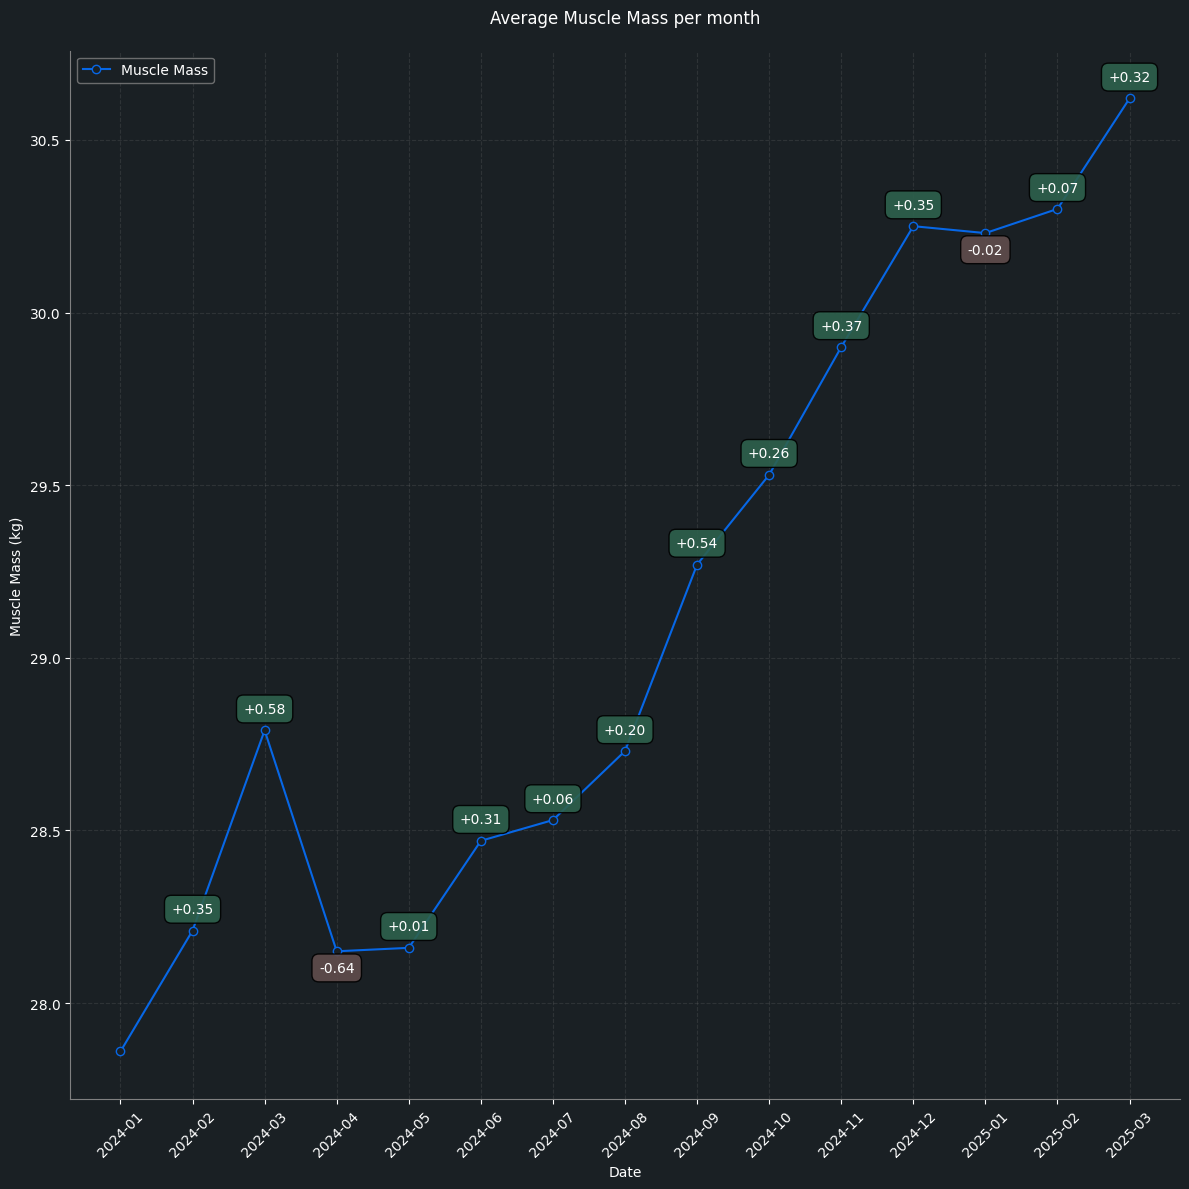

In [6]:
plot_monthly_variation(df_monthly, 'muscle_mass', 'Muscle Mass')

In [ ]:
plot_monthly_variation(df_monthly, 'body_fat_percentage', 'Body Fat Percentage', positive=False)

In [ ]:
plot_monthly_variation(df_monthly, 'body_fat_mass', 'Body Fat Mass')

In [ ]:
# plot muscla mass and body fat mass percentage as stacked bar chart
fig, ax = plt.subplots(figsize=(12, 12))
ax.bar(df_monthly['label'], df_monthly['muscle_mass_percentage_mean'], label='Muscle Mass Percentage')
ax.bar(df_monthly['label'], df_monthly['body_fat_mass_percentage_mean'], label='Body Fat Mass Percentage')
ax.legend()
plt.show()


In [ ]:
# plot muscle mass vs weight
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df_monthly['muscle_mass_mean'], df_monthly['weight_mean'], alpha=0.5)
ax.set_xlabel('Muscle Mass (kg)')
ax.set_ylabel('Weight (kg)')
plt.show()


In [ ]:
# plot body fat mass vs weight
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df_monthly['body_fat_mass_mean'], df_monthly['weight_mean'], alpha=0.5)
ax.set_xlabel('Body Fat Mass (kg)')
ax.set_ylabel('Weight (kg)')
plt.show()